# Visualizing Hyperbolic K-Means
`Drew Wilimitis`

In this notebook, I attempt to extend the idea of Poincaré embeddings and hyperbolic multidimensional scaling by exploiting the representational capacity of these embeddings to apply clustering in hyperbolic space. Given that K-means is a relatively simpler clustering algorithm with existing implementations in the standard Euclidean space, I test an implementation of K-means clustering in  hyperbolic space. <br>
<br>
My hypothesis is that given the demonstrated success of hyperbolic embeddings in learning hierarchical relationships, applying hyperbolic clustering algorithms to hyperbolically embedded data may outperform clustering in euclidean space, specifically on hierarchical datasets.

## Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

## Load libraries and helper functions

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [193]:
# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2) * Y[:, 0]
    mink_pts[:, 1] = 2/(1 - r**2) * Y[:, 1]
    mink_pts[:, 2] = 2/(1 - r**2) * (1 + r**2)/2
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2) * y[0]
    mink_pt[1] = 2/(1 - r**2) * y[1]
    mink_pt[2] = 2/(1 - r**2) * (1 + r**2)/2
    return mink_pt

In [194]:
# define hyperboloid bilinear form
def hyperboloid_dot(u, v):
    return np.dot(u[:-1], v[:-1]) - u[-1]*v[-1]

# hyperboloid distance function
def hyperboloid_dist(u, v):
    return np.arccosh(-1*hyperboloid_dot(u, v))

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 0] / (X[:, 2]+1)
    poincare_pts[:, 1] = X[:, 1] / (X[:, 2]+1)
    return poincare_pts

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[0] / (x[2]+1)
    poincare_pt[1] = x[1] / (x[2]+1)
    return poincare_pt

In [195]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [196]:
# test hyperboloid bilinear form condition
poinc_pts = generate_data(20)
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(hyperboloid_dot(pt, pt), -1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
data = generate_data(20)
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


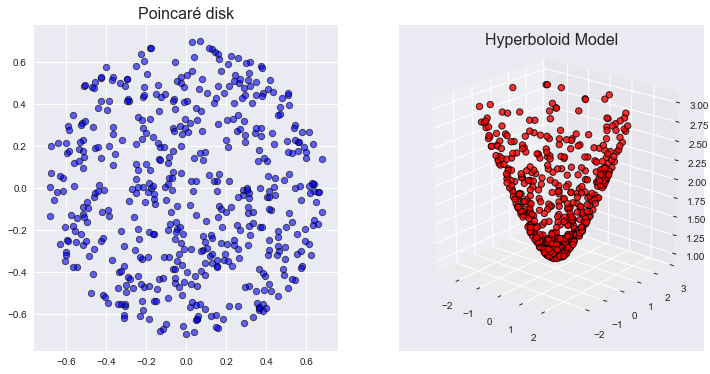

In [197]:
data = generate_data(500, radius=0.5)
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='black', linewidth=1, alpha=0.6)
ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='black', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

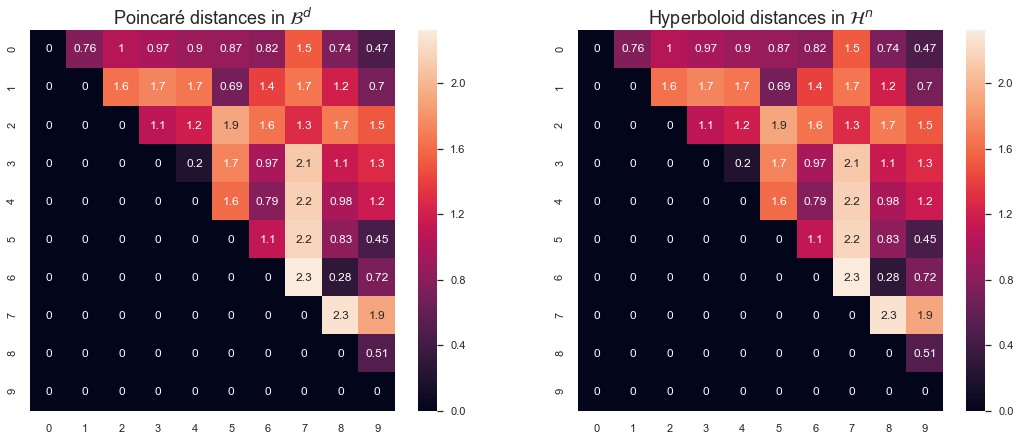

In [198]:
data = generate_data(10, radius=0.5)
mink_pts = poincare_pts_to_hyperboloid(data)
plt.figure(figsize=(18, 7))
sns.set()
plt.subplot(121)
sns.heatmap(poincare_distances(data), annot=True)
plt.title(r'Poincaré distances in $\mathcal{B}^{d}$', size=18)
plt.subplot(122)
sns.heatmap(hyperboloid_distances(mink_pts), annot=True)
plt.title(r'Hyperboloid distances in $\mathcal{H}^{n}$', size=18);

## Hyperboloid Optimization and Fréchet Mean

The **Fréchet mean** defines a the notion of a centroid for any general metric space. <br>

We use gradient descent in the hyperboloid model to find these centroids that define our K-Means algorithm, which will be the centroid coordinates $\Theta \in \mathcal{H}^{n}$ with the minimum squared hyperboloid distances to surrounding points $x_i \in \mathcal{H}^{n}$

$$
\text{Fréchet loss:} \ \ \ \ E(\Theta)=\frac{1}{s} \sum_{i=1}^{s} \mathrm{d}^{2}\left(\Theta, x^{(i)}\right)
$$

Here we have closed form expressions for all gradient terms in the optimization, which we need to implement in our optimization routine.

$$
\nabla_{u}^{\mathbb{R}^{n : 1}} \mathrm{d}_{\mathrm{H}^{n}}(u, v)=-\left(\langle u, v\rangle_{n : 1}^{2}-1\right)^{-1 / 2} \cdot v
$$

$$
\nabla_{\Theta}^{\mathbb{R}^{n+1}} E=\frac{2}{s} \sum_{i=1}^{s}-\mathrm{d}\left(\Theta, x^{(i)}\right) \cdot\left(\left\langle\Theta, x^{(i)}\right\rangle_{n : 1}^{2}-1\right)^{-1 / 2} \cdot x^{(i)}
$$

With update steps using the exponential map to project onto hyperboloid

$$
\nabla_{p}^{\mathbb{H}^{n}} E=\nabla_{p}^{\mathbb{R}^{n : 1}} E+\left\langle p, \nabla_{p}^{\mathbb{R}^{n : 1}} E\right\rangle_{n : 1} \cdot p
$$

$$
\Theta^{\text { new }}=\operatorname{Exp}_{p}\left(-\alpha \cdot \nabla_{\Theta}^{\mathbb{H}^{n}} E\right)
$$

In [199]:
def exp_map(v, theta):
    # v: tangent vector in minkowski space
    # theta: parameter vector in hyperboloid with centroid coordinates
    # project vector v from tangent minkowski space -> hyperboloid
    return np.cosh(norm(v))*theta + np.sinh(norm(v)) * v/norm(v)

def minkowski_distance_gradient(u, v):
    # u,v in hyperboloid
    # returns gradient with respect to u
    return -1*(hyperboloid_dot(u,v)**2-1)**-1/2 * v

In [200]:
def minkowski_loss_gradient(theta, X):
    # X : array with points in hyperboloid cluster
    # theta: parameter vector in hyperboloid with centroid coordinates
    # returns gradient vector
    distances = np.array([-1*hyperboloid_dist(theta, x) for x in X]).reshape(-1,1)
    distance_grads = np.array([minkowski_distance_gradient(theta, x) for x in X])
    return 2*np.mean(distances*distance_grads, axis=0)

def project_to_tangent(theta, minkowski_grad):
    # grad: gradient vector in ambient Minkowski space
    # theta: parameter vector in hyperboloid with centroid coordinates
    # projects to hyperboloid gradient in tangent space
    return minkowski_grad + hyperboloid_dot(theta, minkowski_grad)*theta

def update_theta(theta, hyperboloid_grad, alpha=0.1):
    # theta: parameter vector in hyperboloid with centroid coordinates
    return exp_map(-1*alpha*hyperboloid_grad, theta)

For a sample setting that we can test gradient descent with the Frechet loss, we consider a small set of data $x_1, \ldots x_n$ with some initial $\theta$ as the centroid coordinates and try to minimize the loss.  

In [32]:
def frechet_loss(theta, X):
    s = X.shape[0]
    dist_sq = np.array([hyperboloid_dist(theta, x)**2 for x in X])
    return np.sum(dist_sq) / s

In [349]:
def frechet_mean(theta, X, num_rounds = 10, alpha=0.3, tol = 1e-4, verbose=False):
    print('Initial Frechet loss: ', frechet_loss(theta, X))
    centr_pt = theta.copy()
    centr_pts = []
    losses = []
    for i in range(num_rounds):
        gradient_loss = minkowski_loss_gradient(centr_pt, X)
        tangent_v = project_to_tangent(centr_pt, -gradient_loss)
        centr_pt = update_theta(centr_pt, tangent_v, alpha=alpha)
        centr_pts.append(centr_pt)
        losses.append(frechet_loss(centr_pt, X))
        if verbose:
            print('Epoch ' + str(i+1) + ' complete')
            print('Loss: ', frechet_loss(centr_pt, X))
            print('\n')
    print('Final Frechet Loss: ', frechet_loss(centr_pt, X))
    return centr_pt

## Visualizing Fréchet means

Initial Frechet loss:  3.1174001028014313
Final Frechet Loss:  1.6174497664941232


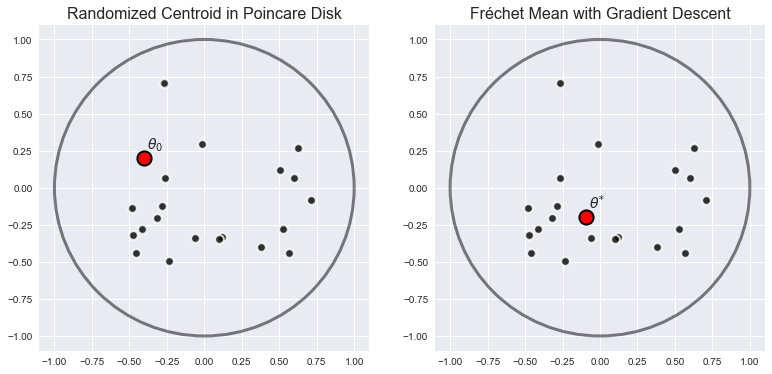

In [313]:
fig = plt.figure(figsize=(13,6))
plt.style.use('seaborn')
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
data = generate_data(20)
x = data[:,0]
y = data[:,1]
theta = np.random.uniform(-0.5, 0.5, size=(2, ))
ax.scatter(x, y, alpha=0.8, s=75, edgecolor='white', c='black', linewidth=2)
ax.scatter(theta[0], theta[1], s = 200, c='red', edgecolor='black', linewidth=2)
ax.text(theta[0]+0.02, theta[1]+0.06, s= r'$\theta_{0}$', size=14)
ax.set_title('Randomized Centroid in Poincare Disk', size=16);

hyp_theta = poincare_pt_to_hyperboloid(theta)
hyp_data = poincare_pts_to_hyperboloid(data)
new_theta = frechet_mean(hyp_theta, hyp_data, num_rounds=20, alpha=0.4)

ax = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
theta = hyperboloid_pt_to_poincare(new_theta)
ax.scatter(x, y, alpha=0.8, s=75, edgecolor='white', c='black', linewidth=2)
ax.scatter(theta[0], theta[1], s = 200, c='red', edgecolor='black', linewidth=2)
ax.text(theta[0]+0.02, theta[1]+0.06, s= r'$\theta^{*}$', size=14)
ax.set_title('Fréchet Mean with Gradient Descent', size=16);

Initial Frechet loss:  2.307400229066185
Final Frechet Loss:  2.358931852119901


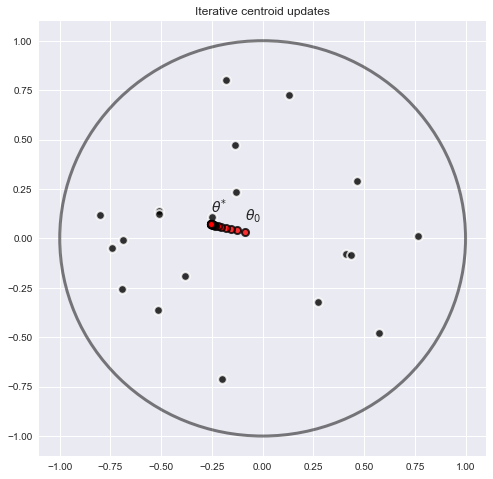

In [346]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

data = generate_data(20)
x = data[:,0]
y = data[:,1]
theta = np.random.uniform(-0.5, 0.5, size=(2, ))
ax.scatter(x, y, alpha=0.8, s=75, edgecolor='white', c='black', linewidth=2)

hyp_theta = poincare_pt_to_hyperboloid(theta)
hyp_data = poincare_pts_to_hyperboloid(data)
new_theta = np.array(frechet_mean(hyp_theta, hyp_data, num_rounds=20, alpha=0.6))
pts = hyperboloid_pts_to_poincare(new_theta)
ax.scatter(pts[:,0], pts[:,1], alpha=0.8, s=50, edgecolor='black', c='red', linewidth=2);
ax.text(pts[0,0], pts[0,1]+0.06, s= r'$\theta_{0}$', size=14);
ax.text(pts[-1,0], pts[-1,1]+0.06, s= r'$\theta^{*}$', size=14)
ax.set_title('Iterative centroid updates');

Initial Frechet loss:  2.8429608184876254
Final Frechet Loss:  1.5034039028684325


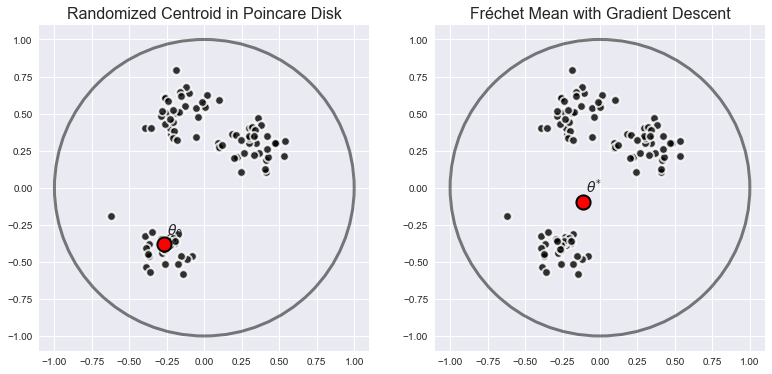

In [352]:
fig = plt.figure(figsize=(13,6))
plt.style.use('seaborn')
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

from sklearn.datasets import make_blobs
centers = [[0.3, 0.3], [-0.23, -0.4], [-0.17, 0.5]]
X, labels = make_blobs(n_samples=100, centers=centers, cluster_std=0.1)
data = X
x = data[:,0]
y = data[:,1]

theta = np.random.uniform(-0.5, 0.5, size=(2, ))
ax.scatter(x, y, alpha=0.8, s=75, edgecolor='white', c='black', linewidth=2)
ax.scatter(theta[0], theta[1], s = 200, c='red', edgecolor='black', linewidth=2)
ax.text(theta[0]+0.02, theta[1]+0.06, s= r'$\theta_{0}$', size=14)
ax.set_title('Randomized Centroid in Poincare Disk', size=16);

hyp_theta = poincare_pt_to_hyperboloid(theta)
hyp_data = poincare_pts_to_hyperboloid(data)
new_theta = frechet_mean(hyp_theta, hyp_data, num_rounds=10, alpha=0.4)

ax = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
theta = hyperboloid_pt_to_poincare(new_theta)
ax.scatter(x, y, alpha=0.8, s=75, edgecolor='white', c='black', linewidth=2)
ax.scatter(theta[0], theta[1], s = 200, c='red', edgecolor='black', linewidth=2)
ax.text(theta[0]+0.02, theta[1]+0.06, s= r'$\theta^{*}$', size=14)
ax.set_title('Fréchet Mean with Gradient Descent', size=16);

Initial Frechet loss:  1.9195571130218214
Final Frechet Loss:  1.1485293468916147


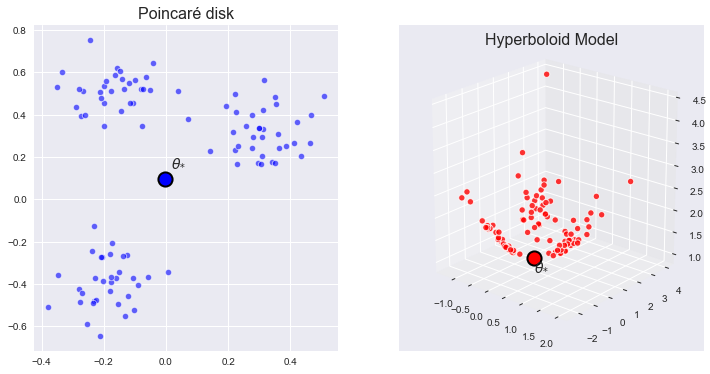

In [306]:
from sklearn.datasets import make_blobs
centers = [[0.3, 0.3], [-0.23, -0.4], [-0.17, 0.5]]
X, labels = make_blobs(n_samples=100, centers=centers, cluster_std=0.1)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]
theta = np.random.uniform(-0.5, 0.5, size=(2, ))

hyp_theta = poincare_pt_to_hyperboloid(theta)
hyp_data = poincare_pts_to_hyperboloid(data)
new_theta = frechet_mean(hyp_theta, hyp_data, num_rounds=10, alpha=0.4)
theta = hyperboloid_pt_to_poincare(new_theta)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(theta[0], theta[1], s = 200, c='blue', edgecolor='black', linewidth=2)
ax.text(theta[0]+0.02, theta[1]+0.06, s= r'$\theta_{*}$', size=14)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.scatter(new_theta[0], new_theta[1], new_theta[2], s = 200, c='red', edgecolor='black', linewidth=2)
ax.text(new_theta[0], new_theta[1], new_theta[2]-0.3, s= r'$\theta_{*}$', size=14)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

### TO DO: Visualizing Centroids and Distance Gradients

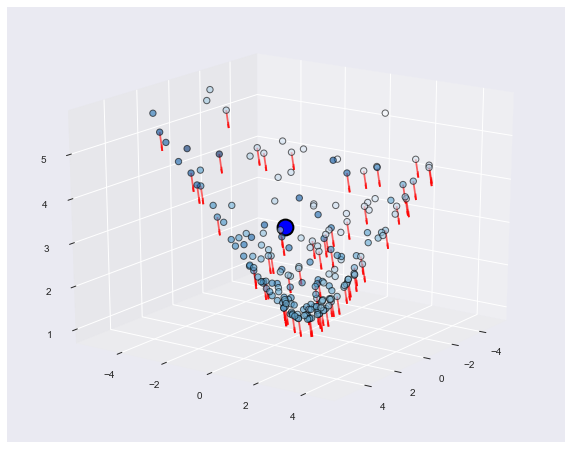

In [428]:
plt.style.use('seaborn')
%matplotlib inline
data = generate_data(200, radius=0.7)
theta = np.random.uniform(-0.6, 0.6, size=(2, ))
hyp_data = poincare_pts_to_hyperboloid(data)
hyp_theta = poincare_pt_to_hyperboloid(theta)
H = hyperboloid_distances(hyp_data)
H_grad = np.zeros((len(hyp_data), 3))
for i in range(len(H_grad)):
    H_grad[i] = minkowski_distance_gradient(hyp_data[i], hyp_theta)

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
xcolors = hyp_data[:,0] - min(hyp_data[:,0].flat)
xcolors = xcolors/max(xcolors.flat)
ax.scatter(hyp_data[:,0], hyp_data[:,1], hyp_data[:,2], facecolors=cm.Blues(xcolors),
           alpha=0.6, s=40, edgecolor='black', linewidth=1)
ax.scatter(hyp_theta[0], hyp_theta[1], hyp_theta[2], c='blue', s=250, 
           edgecolor='black', linewidth=2)
ax.quiver(hyp_data[::3, 0], hyp_data[::3, 1], hyp_data[::3, 2], # <-- starting point of vector
        H_grad[::3, 0], H_grad[::3, 1], H_grad[::3, 2], # <-- directions of vector
        color = 'red', normalize=True, length=0.5, alpha=0.6
    )
ax.view_init(20, 35)
plt.show();

In [62]:
# initialize random cluster assignments
def init_assign(n_samples, n_clusters):
    assignments = np.zeros((n_samples, n_clusters))
    for i in range(n_samples):
        # initialize binary assignment vector
        j = np.random.randint(0, n_clusters)
        assignments[i][j] = 1
    return assignments

# compute mean within cluster and update centroids
def init_centroids(X, assignments):
    n_samples = assignments.shape[0]
    n_clusters = assignments.shape[1]
    dim = X.shape[1]
    new_centroids = np.empty((n_clusters, dim)) 
    for i in range(n_clusters):
        # find total observations in cluster
        n_k = np.sum(C, axis=0)[i]
        # calculate new mean
        new_centroids[i] = np.sum(X[C[:, i] == 1], axis=0) / n_k
    return new_centroids

In [7]:
def update_centroids(self, X):
    dim = X.shape[1]
    new_centroids = np.empty((self.n_clusters, dim)) 
    for i in range(self.n_clusters):
        # find total observations in cluster
        n_k = np.sum(self.assignments, axis=0)[i]
        if n_k == 0:
            new_centroids[i] = np.zeros((1, dim))
        else:
            new_centroids[i] = np.sum(X[self.assignments[:, i] == 1], axis=0) / n_k
    self.centroids = new_centroids

In [6]:
class PoincareKMeans():
    
    def __init__(self,n_clusters=8,n_init=20,max_iter=300,tol=1e-8,verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose =  verbose
        self.labels_ = None
        self.cluster_centers_ = None
        
    def init_assign(self):
        assignments = np.zeros((self.n_samples, self.n_clusters))
        for i in range(self.n_samples):
            # initialize binary assignment vector
            j = np.random.randint(0, self.n_clusters)
            assignments[i][j] = 1
        self.assignments = assignments
        
    def update_centroids(self, X):
        dim = X.shape[1]
        new_centroids = np.empty((self.n_clusters, dim)) 
        for i in range(self.n_clusters):
            # find total observations in cluster
            n_k = np.sum(self.assignments, axis=0)[i]
            if n_k == 0:
                new_centroids[i] = np.zeros((1, dim))
            else:
                new_centroids[i] = np.sum(X[self.assignments[:, i] == 1], axis=0) / n_k
        self.centroids = new_centroids
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, max_epochs=40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        
        self.n_samples = X.shape[0]
        
        # initialize random centroid assignments
        self.init_assign()
        
        # loop through the assignment and update steps
        for j in range(max_epochs):
            self.update_centroids(X)
            for i in range(self.n_samples):
                # zero out current cluster assignment
                self.assignments[i, :] = np.zeros((1, self.n_clusters))
                # find closest centroid mean
                centroid_distances = list(np.sqrt(((X[i] - self.centroids)**2).sum(axis=1)))
                cx = centroid_distances.index(np.min(centroid_distances))
                self.assignments[i][cx] = 1
            if verbose:
                print('Epoch ' + str(j) + ' complete')
                print(self.centroids)
        return self.assignments

In [4]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

## References
---

[1]. Learning graph-structured data using Poincaré embeddings and Riemannian K-means algorithms. Hatem Hajri, Hadi Zaatiti, Georges Hebrail. https://arxiv.org/abs/1907.01662.<br>
[2]. Begelfor, Evgeni and Michael Werman. “The World is not always Flat or Learning Curved Manifolds.” (2005).<br>
[3]. Wilson, Benjamin R. and Matthias Leimeister. “Gradient descent in hyperbolic space.” (2018).